In [104]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import cv2 
import imutils
import time
import pandas as pd



Trackeo en base a un video, guardando los datos en un position.csv. ETA: 30s

In [ ]:
import cv2
import imutils

# Definir el color a trackear en el espacio HSV
greenLower = (60, 55, 90)
greenUpper = (85, 240, 270)

# Crear un DataFrame para almacenar las posiciones y tiempos
position_df = pd.DataFrame()

# Abrir el video
vs = cv2.VideoCapture('VideoCL.mp4')

# Obtener el alto del frame (para ajustar el eje de coordenadas) y el framerate
_, frame = vs.read()
frame_height = frame.shape[0]
fps = vs.get(cv2.CAP_PROP_FPS)

# Calcular el tiempo real por cuadro en la vida real (cada segundo de video son 8 segundos en la vida real)
time_per_frame_real = 1 / (fps * 8)

# Inicializar contador de cuadros
frame_count = 0

# Loop que recorre el video cuadro a cuadro
while True:
    # Leer el siguiente cuadro
    _, frame = vs.read()

    # Si no hay más cuadros, romper el bucle
    if frame is None:
        break

    # Redimensionar el cuadro y aplicarle un desenfoque gaussiano
    frame = imutils.resize(frame, width=600)
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # Crear la máscara para el rango de colores
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Encontrar contornos y determinar el centroide
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

   
    # Continuar si se encontraron contornos
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)

        # Asegurarse de que M["m00"] no sea cero para evitar errores de división
        if M["m00"] > 0:
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            if radius > 10:
                # Dibujar círculo y centroide en el frame
                cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # Solo guardar posiciones si center no es None
    if center is not None:
        # Cambiar el eje y restando el valor de y al alto del frame
        adjusted_center = (center[0], frame_height - center[1])

        # Calcular el tiempo real transcurrido
        time_real = frame_count * time_per_frame_real

        # Guardar la posición y el tiempo en el DataFrame
        position_df = pd.concat([position_df, pd.DataFrame({'x': [adjusted_center[0]], 'y': [adjusted_center[1]], 'time_real': [time_real]})], ignore_index=True)

    # Mostrar los cuadros
    cv2.imshow('Frame', frame)
    cv2.imshow('Mask', mask)

    # Incrementar contador de cuadros
    frame_count += 1

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# Liberar el video y cerrar las ventanas
vs.release()
cv2.destroyAllWindows()

# Guardar las posiciones y tiempos en un archivo CSV
position_df.to_csv('position.csv', index=False)



Pasaje de unidades y generación de gráficos.

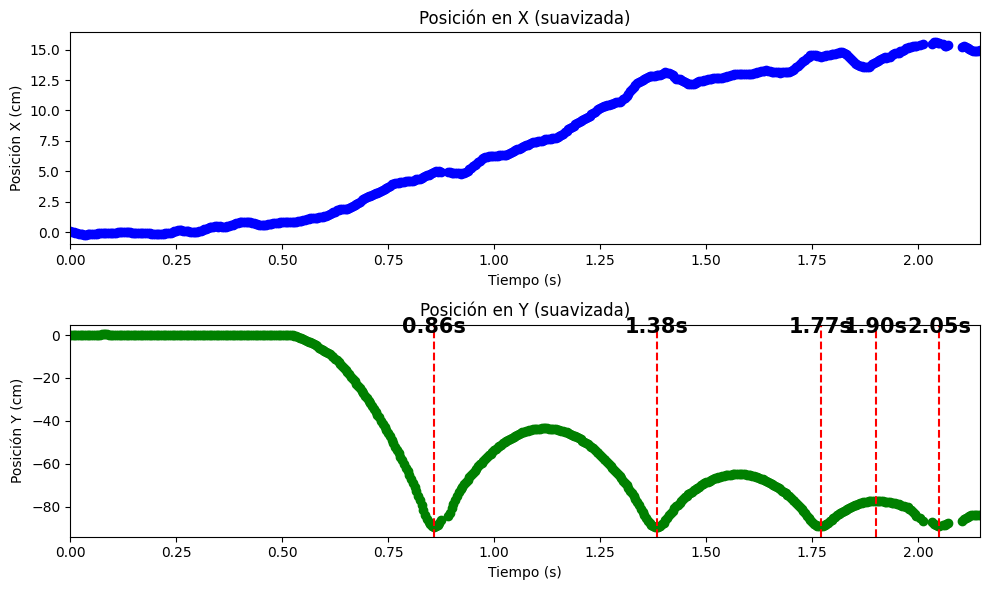

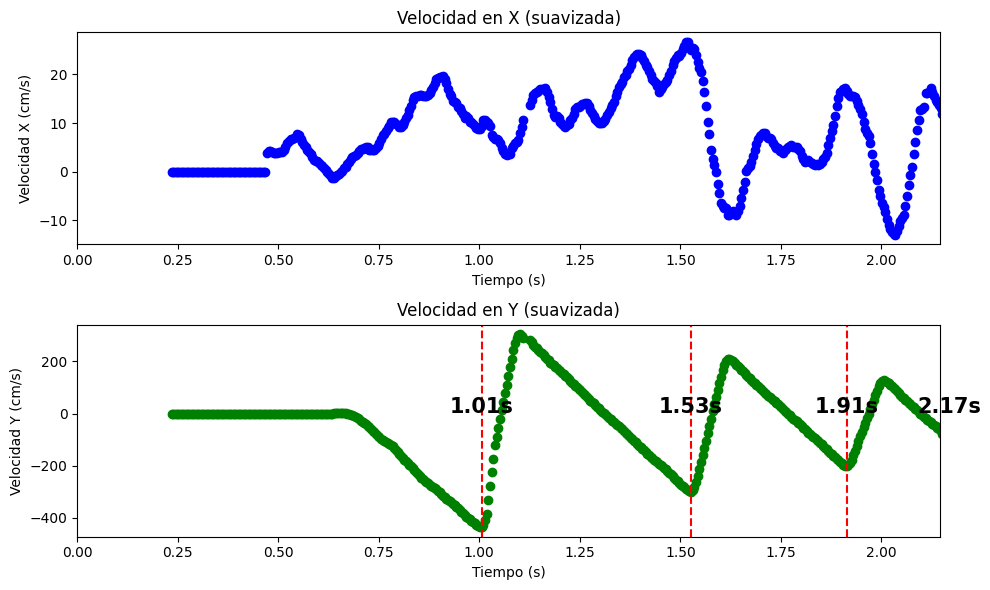

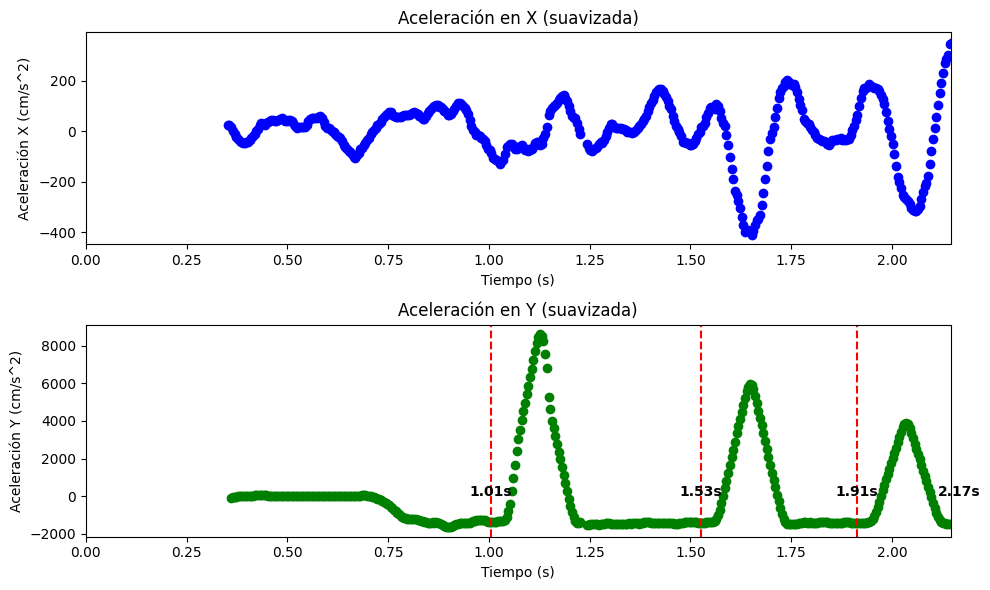

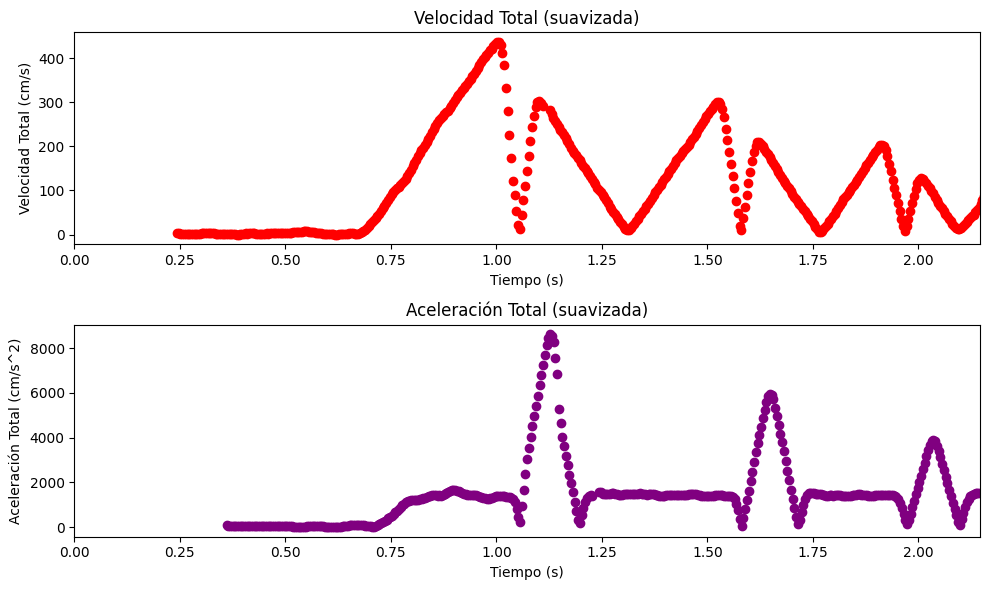

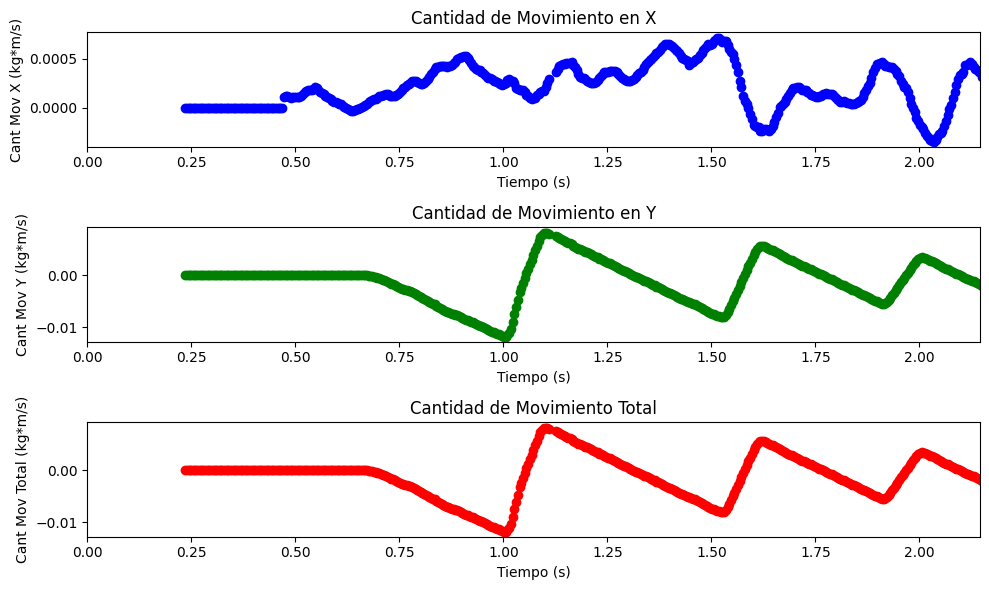

Parametros:
 [ -89.31395154  306.02215887 -330.04233032]
Matriz de Covarianza:
 [[  2741.41327468  -8224.23990259   6130.86626353]
 [ -8224.23990259  24702.56138154 -18437.3611233 ]
 [  6130.86626353 -18437.3611233   13778.55077189]]


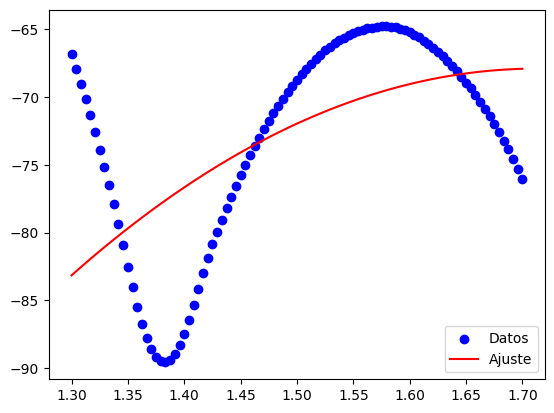

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.signal 

# Leer los datos desde position.csv
df = pd.read_csv('position.csv')

#RELACION PIXEL-METRO.
#La pelota mide 13 pixeles en el video, y sabemos que mide 4cm. Con estos datos calculamos.
pixel_to_cm = 0.3076
# Definir el tamaño del filtro de media móvil para suavizado
SUAVIZADO = -20 #20 puntos (240pts x s)
window_size = 5
window_length_pos = 21
polyorder_pos = 2

# Suavizar las posiciones usando un filtro de media móvil
df["x_smooth"] = df["x"]
df["y_smooth"] = df["y"]
df['x_smooth'] = savgol_filter(df['x'], window_length=window_length_pos, polyorder=polyorder_pos, mode="nearest")
df['y_smooth'] = savgol_filter(df['y'], window_length=window_length_pos, polyorder=polyorder_pos, mode="nearest")

#Convertir posiciones de pixeles a cm
init_x = df.iloc[2]['x_smooth']
init_y = df.iloc[2]['y_smooth']
df['x_smooth_cm'] = (df['x_smooth'] - init_x) * pixel_to_cm
df['y_smooth_cm'] = (df['y_smooth']- init_y) * pixel_to_cm
df['x_cm'] = (df['x'] - init_x) * pixel_to_cm
df['y_cm'] = (df['y'] - init_y) * pixel_to_cm

# Calcular el delta de tiempo (saltando un punto)
df['delta_time'] = df['time_real'].shift(SUAVIZADO) - df['time_real']

# Calcular las velocidades como la diferencia de posiciones dividida por el intervalo de tiempo
# Usar x3 - x1 y y3 - y1 para calcular velocidades
df['vx'] = (df['x_smooth_cm'].shift(SUAVIZADO) - df['x_smooth_cm']) / df['delta_time']
df['vy_raw'] = (df['y_cm'].shift(SUAVIZADO) - df['y_cm']) / df['delta_time']

window_size_vel = 5
# Aplicar un filtro de media móvil a las velocidades
#df['vx'] = df['vx_raw'].rolling(window=window_size_vel, center=True).mean()
df['vy'] = df['vy_raw'].rolling(window=window_size_vel, center=True).mean()

# Calcular la aceleración como la diferencia de velocidades dividida por el intervalo de tiempo
# Usar v3 - v1 y alinearla con el tiempo intermedio
df['ax'] = (df['vx'].shift(SUAVIZADO) - df['vx']) / (df['delta_time'])
df['ay'] = (df['vy'].shift(SUAVIZADO) - df['vy']) / (df['delta_time'])

# Calcular la velocidad total (magnitud)
df['v_total'] = np.sqrt(df['vx']**2 + df['vy']**2)

# Calcular la aceleración total (magnitud)
df['a_total'] = np.sqrt(df['ax']**2 + df['ay']**2)


# CANTIDAD DE MOVIMIENTO
masa_pelota = 0.0027  # en kg
df['px'] = masa_pelota * (df['vx'] / 100) #Porque df['vx'] tiene los valores en en cm/s  
df['py'] = masa_pelota * (df['vy'] / 100) #Porque df['vy'] tiene los valores en en cm/s  

df['p_total'] = masa_pelota * (df['v_total'] / 100) # ya que v_total es la magnitud de la velocidad, el 100 porque esta en cm/s


# Guardar los datos en un nuevo archivo CSV
df[['time_real', 'x_cm', 'y_cm', 'vx', 'vy', 'ax', 'ay', 'v_total', 'a_total', 'px', 'py', 'p_total']].to_csv('processed_data.csv', index=False)

# Obtener los límites del tiempo
time_min = df['time_real'].min()
time_max = df['time_real'].max()

# Desfase temporal en segundos
delay = 0.229 *(1+0.00125*-SUAVIZADO) #(2 * sampling_rate / window_length)

# Gráfico 1: Posición en X e Y en gráficos separados

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(df['time_real'], df['x_smooth_cm'], label='Posición X', color='blue')
plt.title('Posición en X (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición X (cm)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.subplot(2, 1, 2)
plt.scatter(df['time_real'], df['y_cm'], label='Posición Y', color='green')
plt.title('Posición en Y (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición Y (cm)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

#MINIMOS LOCALES POSICION
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_y = scipy.signal.argrelextrema(df['y_smooth_cm'].values, np.less)[0]

# Filtrar los mínimos donde la posicion Y sea menor a -20
minimos_indices_y_filtrados = [
    i for i in minimos_indices_y if df['y_smooth_cm'].values[i] < -20
]
minimos_tiempos_y_filtrados = df['time_real'].values[minimos_indices_y_filtrados]

# Dibujar líneas verticales en los mínimos locales filtrados y anotar el tiempo en negrita
for tiempo_minimo in minimos_tiempos_y_filtrados:
    plt.axvline(x=tiempo_minimo, color='red', linestyle='--', label='Mínimo local < -20')

    # Anotar el tiempo en negrita y en una posición adecuada
    plt.text(tiempo_minimo, 1, f'{tiempo_minimo:.2f}s', 
             color='black', ha='center',
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()



# Gráfico 2: Velocidad en X y Velocidad en Y en gráficos separados
plt.figure(figsize=(10, 6))

vel_x_plot = np.where(df['time_real'] <= delay, 0, df['vx'])
plt.subplot(2, 1, 1)
plt.scatter(df['time_real'] + delay, vel_x_plot, label='Velocidad X', color='blue')
plt.title('Velocidad en X (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad X (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

vel_y_plot = np.where(df['time_real'] <= delay, 0, df['vy'])
plt.subplot(2, 1, 2)
plt.scatter(df['time_real'] + delay, vel_y_plot, label='Velocidad Y', color='green')
plt.title('Velocidad en Y (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Y (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

#MINIMOS LOCALES VELOCIDAD
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_vy = scipy.signal.argrelextrema(df['vy'].values, np.less)[0]

# Filtrar los mínimos donde la velocidad Y sea menor a -20
minimos_indices_vy_filtrados = [
    i for i in minimos_indices_vy if df['vy'].values[i] < -20
]
minimos_tiempos_vy_filtrados = df['time_real'].values[minimos_indices_vy_filtrados]

# Dibujar líneas verticales en los mínimos locales filtrados y anotar el tiempo en negrita
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo local < -20')

    # Anotar el tiempo en negrita y en una posición adecuada
    plt.text(tiempo_minimo + delay, 1, f'{tiempo_minimo + delay:.2f}s', 
             color='black', ha='center',
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico 3: Aceleración en X y Aceleración en Y en gráficos separados
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(df['time_real'] + 1.5*delay, df['ax'], label='Aceleración X', color='blue')
plt.title('Aceleración en X (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración X (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.subplot(2, 1, 2)
plt.scatter(df['time_real']+ 1.5*delay, df['ay'], label='Aceleración Y', color='green')
plt.title('Aceleración en Y (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Y (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

#MINIMOS LOCALES ACELERACION
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_ay = scipy.signal.argrelextrema(df['ay'].values, np.less)[0]

# Filtrar los mínimos donde la velocidad Y sea menor a -20
minimos_indices_ay_filtrados = [
    i for i in minimos_indices_ay if df['ay'].values[i] < -50 and not (-970 < df['ay'].values[i] < -990)
]
minimos_tiempos_ay_filtrados = df['time_real'].values[minimos_indices_ay_filtrados]

# Dibujar líneas verticales en los mínimos locales filtrados y anotar el tiempo en negrita
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo local < -20')

    # Anotar el tiempo en negrita y en una posición adecuada
    plt.text(tiempo_minimo + delay, 1, f'{tiempo_minimo + delay:.2f}s', 
             color='black', ha='center',
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico 4: Velocidad total y Aceleración total en gráficos separados
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(df['time_real'] + delay, df['v_total'], label='Velocidad Total', color='red')
plt.title('Velocidad Total (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Total (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.subplot(2, 1, 2)
plt.scatter(df['time_real'] + delay * 1.5, df['a_total'], label='Aceleración Total', color='purple')
plt.title('Aceleración Total (suavizada)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Total (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()

# Gráfico 5: Cantidad de Movimiento respecto al tiempo
p_x_plot = np.where(df['time_real'] <= delay, 0, df['px'])

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.scatter(df['time_real'] + delay, p_x_plot, label='Cant Mov X', color='blue')
plt.title('Cantidad de Movimiento en X')
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov X (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

p_y_plot = np.where(df['time_real'] <= delay, 0, df['py'])

plt.subplot(3, 1, 2)
plt.scatter(df['time_real'] + delay, p_y_plot, label='Cant Mov Y', color='green')
plt.title('Cantidad de Movimiento en Y')
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Y (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0


p_total_plot = np.where(df['time_real'] <= delay, 0, df['py'])

plt.subplot(3, 1, 3)
plt.scatter(df['time_real'] + delay, p_total_plot, label='Cant Mov Total', color='red')
plt.title('Cantidad de Movimiento Total')
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Total (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()

#MANEJO DE ERRORES

from scipy.optimize import curve_fit
def posicion_y(t, a, b, c):
    y = a * t**2 + b * t + c 
    return y

filtered_y_values = df[(df['time_real'] >= 1.3) & (df['time_real'] <= 1.7)]['y_smooth_cm'] #DESDE QUE LA SUELTA AL PIQUE
filtered_time_values = df[(df['time_real'] >= 1.3) & (df['time_real'] <= 1.7)]['time_real']


params, covariance = curve_fit(posicion_y, filtered_time_values, filtered_y_values)

print("Parametros:\n", params)
print("Matriz de Covarianza:\n", covariance)

x_fit = np.linspace(min(filtered_time_values), max(filtered_time_values), 97)
y_fit = posicion_y(filtered_time_values, *params)

# Graficar datos y ajuste
plt.scatter(filtered_time_values, filtered_y_values, label='Datos', color='blue')
plt.plot(x_fit, y_fit, label='Ajuste', color='red')
plt.legend()
plt.show()










In [107]:
import plotly.graph_objects as go
y_max = mask.shape[0]
x_max = mask.shape[1]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = position_df['x'],
    y = y_max - position_df['y'], # El 0,0 esta arriba a la izquierda
    mode='markers+lines',
    marker=dict(size=8, color='rgba(219, 64, 82, 0.8)', line=dict(width=2, color='rgba(219, 64, 82, 0.8)')),
    name='Datos de Coordenadas'
))